In [14]:
import os
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [15]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
class CocoDetectionDataset(Dataset):
    def __init__(self, json_path, transform=None):
        with open(json_path) as f:
            data = json.load(f)
        self.annotations = data["annotations"]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image = Image.open(ann["file_path"]).convert("RGB")
        bbox = ann["bbox"]
        category = ann["category_id"]

        if self.transform:
            image = self.transform(image)

        target = {
            "boxes": torch.tensor([bbox], dtype=torch.float32),
            "labels": torch.tensor([category], dtype=torch.int64)
        }

        return image, target

In [16]:
import torch
import torch.nn as nn
import numpy as np

class PositionEmbedding(nn.Module):
    def __init__(self, d_model=256, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return self.pe[:, :x.size(1)].to(x.device)

In [17]:
class SimplePatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [18]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=False
        )

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        return self.transformer(src, tgt, src_mask, tgt_mask)

In [19]:
class DETR(nn.Module):
    def __init__(self, num_classes=2, num_queries=100, d_model=256):
        super().__init__()
        self.backbone = SimplePatchEmbed(embed_dim=d_model)

        self.pos_embed = PositionEmbedding(d_model)
        self.query_embed = nn.Embedding(num_queries, d_model)
        self.transformer = TransformerEncoderDecoder(d_model=d_model)

        self.class_embed = nn.Linear(d_model, num_classes)
        self.bbox_embed = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        pos = self.pos_embed(x)
        x = x + pos

        x = x.permute(1, 0, 2)
        queries = self.query_embed.weight.unsqueeze(1).repeat(1, x.shape[1], 1)

        hs = self.transformer(x, queries)
        hs = hs.permute(1, 0, 2)

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs)

        return {"pred_logits": outputs_class, "pred_boxes": outputs_coord}

In [20]:
class SimpleDETRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        self.bbox_loss = nn.SmoothL1Loss()

    def forward(self, outputs, targets):
        pred_logits = outputs["pred_logits"][:, 0, :]
        pred_boxes = outputs["pred_boxes"][:, 0, :]

        target_labels = torch.cat([t["labels"] for t in targets], dim=0).to(pred_logits.device)
        target_boxes = torch.cat([t["boxes"] for t in targets], dim=0).to(pred_boxes.device)

        loss_cls = self.cls_loss(pred_logits, target_labels)
        loss_bbox = self.bbox_loss(pred_boxes, target_boxes)

        return loss_cls + loss_bbox

In [21]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, targets in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [22]:
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validating"):
            images = images.to(device)
            outputs = model(images)

            pred_logits = outputs["pred_logits"][:, 0, :]
            preds = pred_logits.argmax(dim=1).cpu().numpy()
            labels = torch.cat([t["labels"] for t in targets], dim=0).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    prec = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")

    return acc, f1, prec, recall

In [56]:
def show_image_with_boxes(image_tensor, boxes, labels=None):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    h, w, _ = image.shape

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)

    for box in boxes:
        x, y, bw, bh = box
        rect = plt.Rectangle((x * w, y * h), bw * w, bh * h,
                             edgecolor='red', facecolor='none', linewidth=8)
        ax.add_patch(rect)

    plt.show()

In [57]:
def test_model(model, dataloader, device=device):
    count = 0
    model.eval()
    with torch.no_grad():  
        for batch in dataloader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                images, _ = batch
            else:
                images = batch
            count += 1
            images = images.to(device)
            outputs = model(images)

            boxes = outputs["pred_boxes"][:, 0, :].cpu()

            show_image_with_boxes(images[0], boxes)
    return count

In [25]:
dataset = CocoDetectionDataset("annotations_with_paths.json", transform=transform)
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len-train_len-val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    return images, list(targets)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=4, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle = False, collate_fn=collate_fn)

model = DETR().to(device)
criterion = SimpleDETRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_f1 = 0.0
best_model_path = "best_detr.pth"

for epoch in range(15):
    print(f"Epoch {epoch + 1}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    acc, f1, prec, recall = evaluate(model, val_loader)
    print(f"Bounding box Loss: {train_loss:.4f}")

    if f1 >= best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), best_model_path)
print(f"Best model saved to {best_model_path}")

model.load_state_dict(torch.load(best_model_path))
model.to(device)
test_model(model, test_loader)

Epoch 1


Validating: 100%|██████████| 439/439 [00:38<00:00, 11.45it/s]


Bounding box Loss: 457.2298
Epoch 2


Validating: 100%|██████████| 439/439 [00:38<00:00, 11.50it/s]


Bounding box Loss: 457.2188
Epoch 3


Validating: 100%|██████████| 439/439 [00:37<00:00, 11.80it/s]


Bounding box Loss: 457.2502
Epoch 4


Validating: 100%|██████████| 439/439 [00:38<00:00, 11.48it/s]


Bounding box Loss: 457.2477
Epoch 5


Validating: 100%|██████████| 439/439 [00:48<00:00,  8.97it/s]


Bounding box Loss: 457.1846
Epoch 6


Validating: 100%|██████████| 439/439 [00:44<00:00,  9.92it/s]


Bounding box Loss: 457.1098
Epoch 7


Validating: 100%|██████████| 439/439 [00:38<00:00, 11.49it/s]


Bounding box Loss: 457.1595
Epoch 8


Validating: 100%|██████████| 439/439 [02:09<00:00,  3.39it/s]


Bounding box Loss: 457.1106
Epoch 9


Validating: 100%|██████████| 439/439 [01:46<00:00,  4.12it/s]


Bounding box Loss: 457.1755
Epoch 10


Validating: 100%|██████████| 439/439 [01:27<00:00,  5.03it/s]


Bounding box Loss: 457.2008
Epoch 11


Validating: 100%|██████████| 439/439 [00:37<00:00, 11.84it/s]


Bounding box Loss: 457.2113
Epoch 12


Validating: 100%|██████████| 439/439 [03:02<00:00,  2.41it/s]


Bounding box Loss: 457.2117
Epoch 13


Validating: 100%|██████████| 439/439 [02:45<00:00,  2.65it/s]


Bounding box Loss: 457.1999
Epoch 14


Validating: 100%|██████████| 439/439 [02:53<00:00,  2.52it/s]


Bounding box Loss: 457.2060
Epoch 15


Validating: 100%|██████████| 439/439 [02:58<00:00,  2.46it/s]


Bounding box Loss: 457.1140
Best model saved to best_detr.pth


In [59]:
def show_image_with_boxes(image_tensor, boxes, labels=None):
    import matplotlib.pyplot as plt
    import numpy as np

    image = image_tensor.cpu().permute(1, 2, 0).numpy()
    H, W, _ = image.shape

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    for box in boxes:
        cx, cy, bw, bh = box
        # convert center → top-left
        x1 = (cx - bw / 2) * W
        y1 = (cy - bh / 2) * H
        rect = plt.Rectangle(
            (x1, y1),
            bw * W,
            bh * H,
            edgecolor="red",
            facecolor="none",
            linewidth=2,
        )
        ax.add_patch(rect)

    ax.axis("off")
    plt.show()


def test_model(model, dataloader, device=device, threshold=0.5):
    model.to(device).eval()
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                images, _ = batch
            else:
                images = batch

            images = images.to(device)
            outputs = model(images)

            logits = outputs["pred_logits"]
            probs = logits.softmax(-1)

            scores = probs[0, :, 1]
            keep = scores > threshold

            boxes = outputs["pred_boxes"][0][keep].cpu()
            show_image_with_boxes(images[0], boxes)
            break


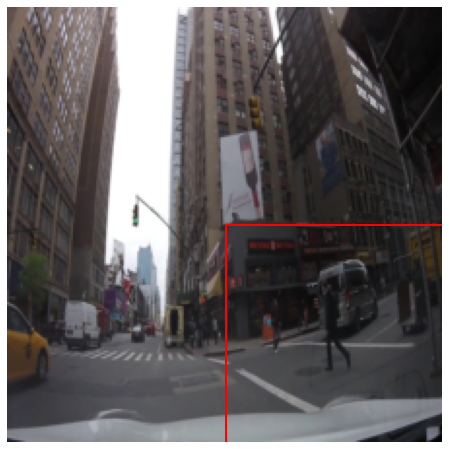

In [60]:
%matplotlib inline
test_model(model, test_loader)